# Подготовка модели распознавания рукописных букв и цифр

1. Загрузка данных с применением:

    трансформации

    отражения

    нормализации

2. Создание словаря меток

3. Загрузка данных с применением:

    Eroding, Dilating и Smoothing Images

    трансформации

    отражения

    нормализации

4. Создание загрузчиков

5. Создание класса модели и обучение

6. Просмотр тестовых предсказаний

7. Соранение модели

# Библиотеки

In [1]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image

import torchvision.transforms.functional as TF
import cv2


# Получение, трансформация, нормализация и контроль данных

In [2]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

In [3]:
# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [4]:
# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))


1. **Цель поворота и отражения данных**: Данные EMNIST могут отображаться повернутыми на 90° и отраженными по диагонали для увеличения разнообразия обучающей выборки. Это помогает модели стать более устойчивой к различным ориентациям и стилям написания, что важно для распознавания рукописных букв и цифр в реальных условиях.

2. **Влияние на модель**: Обученная на таких данных модель будет лучше справляться с вариациями в написании, включая наклон, поворот и зеркальное отображение символов. Это повышает обобщающую способность модели, что делает ее более надежной при предсказании рукописных символов.

3. **Необходимость дополнительных преобразований**: Для обучения модели не обязательно дополнительно отражать и поворачивать данные, если они уже представлены в различных ориентациях. Однако, если данные будут использоваться для предсказания в условиях, где буквы могут быть написаны под разными углами или в зеркальном отображении, добавление таких трансформаций может улучшить результаты.

Citations:
[1] EMNIST — Torchvision 0.19 documentation - PyTorch https://pytorch.org/vision/0.19/generated/torchvision.datasets.EMNIST.html

In [5]:
# получение маппинга
with open('data/EMNIST/raw/emnist-balanced-mapping.txt', 'r') as f:
    mapping = f.readlines()

#mapping

In [6]:
# Создаем словарь соответствий
label_dict = {}
for entry in mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

In [7]:
# Подсчитываем количество тренировочных семплов для каждого лейбла
label_counts = np.bincount(train_data.targets)

# Выводим символы и количество семплов
print("Количество тренировочных семплов для каждого символа:")
for label, count in enumerate(label_counts):
    if count > 0:  # Печатаем только те лейблы, которые встречаются в выборке
        symbol = label_dict.get(label, '?')  # Получаем символ
        print(f'Символ: {symbol}, Лейбл: {label}, Количество: {count}')

Количество тренировочных семплов для каждого символа:
Символ: 0, Лейбл: 0, Количество: 2400
Символ: 1, Лейбл: 1, Количество: 2400
Символ: 2, Лейбл: 2, Количество: 2400
Символ: 3, Лейбл: 3, Количество: 2400
Символ: 4, Лейбл: 4, Количество: 2400
Символ: 5, Лейбл: 5, Количество: 2400
Символ: 6, Лейбл: 6, Количество: 2400
Символ: 7, Лейбл: 7, Количество: 2400
Символ: 8, Лейбл: 8, Количество: 2400
Символ: 9, Лейбл: 9, Количество: 2400
Символ: A, Лейбл: 10, Количество: 2400
Символ: B, Лейбл: 11, Количество: 2400
Символ: C, Лейбл: 12, Количество: 2400
Символ: D, Лейбл: 13, Количество: 2400
Символ: E, Лейбл: 14, Количество: 2400
Символ: F, Лейбл: 15, Количество: 2400
Символ: G, Лейбл: 16, Количество: 2400
Символ: H, Лейбл: 17, Количество: 2400
Символ: I, Лейбл: 18, Количество: 2400
Символ: J, Лейбл: 19, Количество: 2400
Символ: K, Лейбл: 20, Количество: 2400
Символ: L, Лейбл: 21, Количество: 2400
Символ: M, Лейбл: 22, Количество: 2400
Символ: N, Лейбл: 23, Количество: 2400
Символ: O, Лейбл: 24

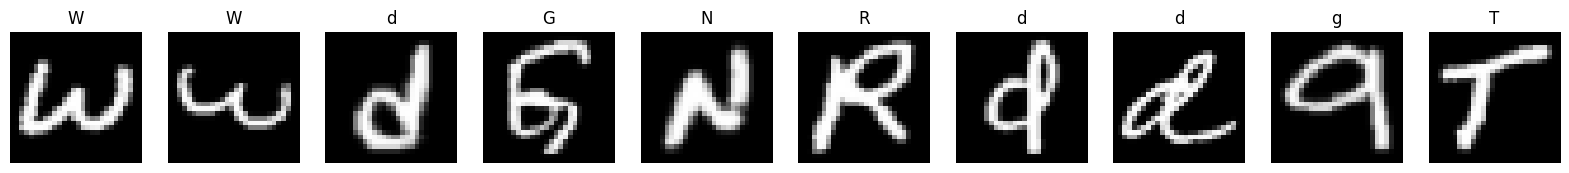

In [8]:
# Проверяем корректность изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()


In [9]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [10]:
# простая модель
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Свертка с 32 фильтрами
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Свертка с 64 фильтрами
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Полносвязный слой
        self.fc2 = nn.Linear(128, 47)  # Выходной слой для 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Применение свертки и активации ReLU
        x = self.pool(F.relu(self.conv2(x)))  # Применение свертки и активации ReLU
        x = x.view(-1, 64 * 7 * 7)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)  
        return x

In [11]:
# Очищаем состояние для последующей модели
def clear_training_state(model, optimizer):
    # Удаляем все параметры и градиенты
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer.state.clear()  # Очищаем состояние оптимизатора
    optimizer.param_groups.clear()  # Очищаем группы параметров

In [12]:
# Используем функцию для очистки состояния
#clear_training_state(model, optimizer)

# Инициализация модели
model_cnn = CNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [13]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

KeyboardInterrupt: 

In [ ]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'model_cnn.ckpt')

## Eroding, Dilating и Smoothing Images

При работе с рукописными знаками из набора данных EMNIST (47 классов) важно понимать, как различные методы обработки изображений могут помочь улучшить качество данных перед подачей их в модель. Рассмотрим методы Eroding, Dilating и Smoothing Images, а также их применение на разных этапах обработки данных.
1. Eroding (Эрозия)
Описание: Эрозия уменьшает размеры объектов в изображении, удаляя пиксели по краям. Это может помочь удалить шум и мелкие детали, которые могут мешать классификации. Когда применять:

    На этапе предобработки данных, прежде чем подавать изображения в модель. Эрозия может помочь избавиться от мелких шумов или артефактов, которые могут быть результатом процесса сканирования.

Ожидаемые результаты:

    Уменьшение фона и шумов, что может улучшить качество классификации, особенно если данные содержат много помех.

2. Dilating (Дилатация)
Описание: Дилатация увеличивает размеры объектов в изображении, добавляя пиксели к краям. Это может помочь соединить разрозненные части символов. Когда применять:

    После эрозии для восстановления структуры символов. Если после эрозии символы стали слишком тонкими или разорванными, дилатация может помочь восстановить их форму.

Ожидаемые результаты:

    Улучшение связности символов и повышение их четкости, что может привести к более точной классификации.

3. Smoothing Images (Сглаживание изображений)
Описание: Сглаживание уменьшает шум в изображениях, делая их более гладкими и менее резкими. Это может быть выполнено с помощью различных фильтров, таких как гауссовский фильтр. Когда применять:

    На этапе предобработки данных перед подачей в модель. Сглаживание помогает улучшить качество изображений и уменьшить влияние шума на предсказания модели.

Ожидаемые результаты:

    Уменьшение влияния шума и улучшение качества изображений, что может повысить точность классификации.


In [ ]:
'''Для обработки изображений х EMNIST с использованием методов Eroding, Dilating и Smoothing Images, 
 создадим функцию, для предобработки перед передачей изображений в модель'''


def preprocess_image(img):
    # Преобразуем изображение PIL в массив NumPy
    img_np = np.array(img)

    # Применяем сглаживание (Gaussian Blur)
    img_blurred = cv2.GaussianBlur(img_np, (5, 5), 0)

    # Применяем эрозию
    kernel = np.ones((3, 3), np.uint8)
    img_eroded = cv2.erode(img_blurred, kernel, iterations=1)

    # Применяем дилатацию
    img_dilated = cv2.dilate(img_eroded, kernel, iterations=1)

    # Преобразуем обратно в PIL
    img_processed = Image.fromarray(img_dilated)

    return img_processed




In [ ]:
# использованием методов Eroding, Dilating и Smoothing Images
# Загрузка обучающего набора данных с трансформациями
train_data_eds = EMNIST('data/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [ ]:
# использованием методов Eroding, Dilating и Smoothing Images
# Загрузка тестового набора данных с трансформациями
test_data_eds = EMNIST('data/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ 
                    # Применяем обработку изображения
                    preprocess_image,
                    # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

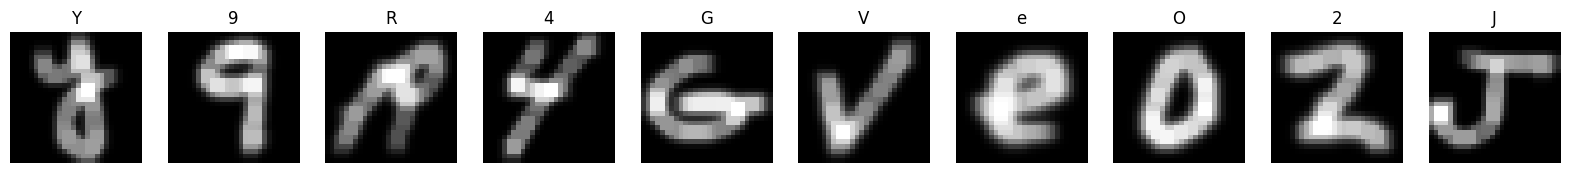

In [ ]:
# Проверяем корректность изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data_eds))
    #print('Random index:', random_index)
    image, label = train_data_eds[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()


In [ ]:
# Создание загрузчиков данных
train_loader_eds = DataLoader(train_data_eds, batch_size=64, shuffle=True)
val_loader_eds = DataLoader(test_data_eds, batch_size=64, shuffle=False)

## Моделирование

Сверточная нейронная сеть (CNN)

In [ ]:
#упрощенная модель

class SimplifiedCNNModel(nn.Module):
    def __init__(self):
        super(SimplifiedCNNModel, self).__init__()
        # Первый свертка + активация + подвыборка
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Уменьшено до 16 фильтров
        self.bn1 = nn.BatchNorm2d(16)  # Нормализация
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        
        # Второй свертка + активация + подвыборка
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Уменьшено до 32 фильтров
        self.bn2 = nn.BatchNorm2d(32)  # Нормализация
        
        # Полносвязные слои
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Измените размер в зависимости от входного размера
        self.fc2 = nn.Linear(128, 47)  # Выходной слой для 47 классов
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка 1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Свертка 2
        x = x.view(-1, 32 * 7 * 7)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута
        x = self.fc2(x)
        return x

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Первый свертка + активация + подвыборка
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 32 фильтра
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        # Второй свертка + активация + подвыборка
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 фильтра
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        # Третий свертка
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 фильтров
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Измените размер в зависимости от входного размера
        self.fc2 = nn.Linear(256, 47)  # Выходной слой для 47 классов
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка 1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Свертка 2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Свертка 3
        x = x.view(-1, 128 * 3 * 3)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута
        x = self.fc2(x)
        return x

In [ ]:
# Используем функцию для очистки состояния
clear_training_state(model_cnn, optimizer)

# Инициализация модели
model_cnn_eds = CNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn_eds.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [ ]:
n_epochs = 10

for epoch in range(n_epochs):
    model_cnn_eds.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader_eds:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn_eds(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader_eds):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn_eds(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader_eds.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 0.7395
Validation Accuracy: 0.8083
Epoch 2/10, Loss: 0.4322
Validation Accuracy: 0.8159
Epoch 3/10, Loss: 0.3744
Validation Accuracy: 0.8139
Epoch 4/10, Loss: 0.3387
Validation Accuracy: 0.8237
Epoch 5/10, Loss: 0.3105
Validation Accuracy: 0.8349
Epoch 6/10, Loss: 0.2865
Validation Accuracy: 0.8242
Epoch 7/10, Loss: 0.2669
Validation Accuracy: 0.8249
Epoch 8/10, Loss: 0.2487
Validation Accuracy: 0.8177
Epoch 9/10, Loss: 0.2340
Validation Accuracy: 0.8041
Epoch 10/10, Loss: 0.2179
Validation Accuracy: 0.7991


In [ ]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn_eds.state_dict(), 'model_cnn_eds.ckpt')

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Первый свертка + активация + подвыборка
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 32 фильтра
        self.bn1 = nn.BatchNorm2d(32)  # Нормализация
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        # Второй свертка + активация + подвыборка
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 фильтра
        self.bn2 = nn.BatchNorm2d(64)  # Нормализация
        # Третий свертка
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 фильтров
        self.bn3 = nn.BatchNorm2d(128)  # Нормализация
        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Измените размер в зависимости от входного размера
        self.fc2 = nn.Linear(256, 47)  # Выходной слой для 47 классов
        self.dropout = nn.Dropout(0.5)  # Дропаут для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Свертка 1
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Свертка 2
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Свертка 3
        x = x.view(-1, 128 * 3 * 3)  # Преобразование в вектор для полносвязного слоя
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Применение дропаута
        x = self.fc2(x)
        return x

In [ ]:
# Используем функцию для очистки состояния
clear_training_state(model_cnn_eds, optimizer)

# Инициализация модели
model = CNNModel()

# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [ ]:
# Инициализация модели
model = CNNModel()

In [ ]:
n_epochs = 10

for epoch in range(n_epochs):
    model.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 3.8529
Validation Accuracy: 0.0239
Epoch 2/10, Loss: 3.8529
Validation Accuracy: 0.0239
Epoch 3/10, Loss: 3.8529
Validation Accuracy: 0.0239
Epoch 4/10, Loss: 3.8529
Validation Accuracy: 0.0239
Epoch 5/10, Loss: 3.8529
Validation Accuracy: 0.0239
Epoch 6/10, Loss: 3.8529
Validation Accuracy: 0.0239


KeyboardInterrupt: 

In [ ]:
# Сохранение модели в формате .ckpt
torch.save(model.state_dict(), 'model_last.ckpt') 

Random index: 12585
image shape: torch.Size([1, 1, 28, 28])


AttributeError: 'CNNModel' object has no attribute 'pool'

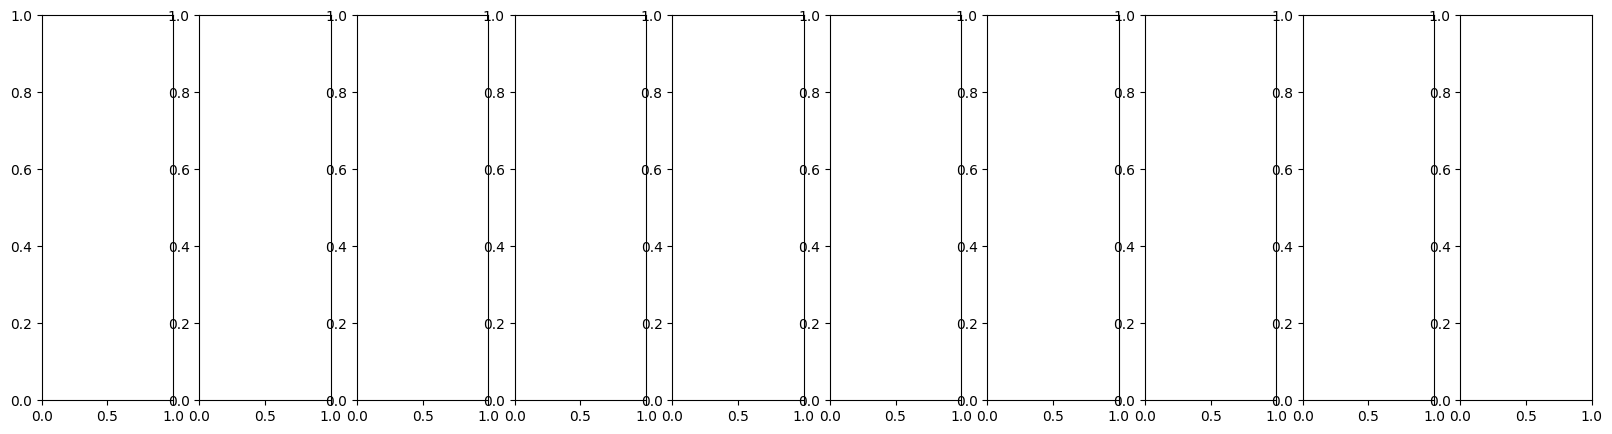

In [ ]:
def predict(image):
    # Применяем преобразования к изображению, если они требуются
    # image = transform(input_image)  # Примените необходимые преобразования
    # Убедитесь, что изображение имеет форму (1, 1, H, W) для модели
    if image.dim() == 2:  # Если изображение 2D (H, W)
        image = image.unsqueeze(0)  # Добавляем размер канала
    image = image.unsqueeze(0)  # Добавляем размер батча

    print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем предсказанную метку
        print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.squeeze(0).numpy()  # Убираем размер канала и преобразуем в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()


Random index: 42427
image shape: torch.Size([1, 1, 28, 28])


AttributeError: 'CNNModel' object has no attribute 'pool'

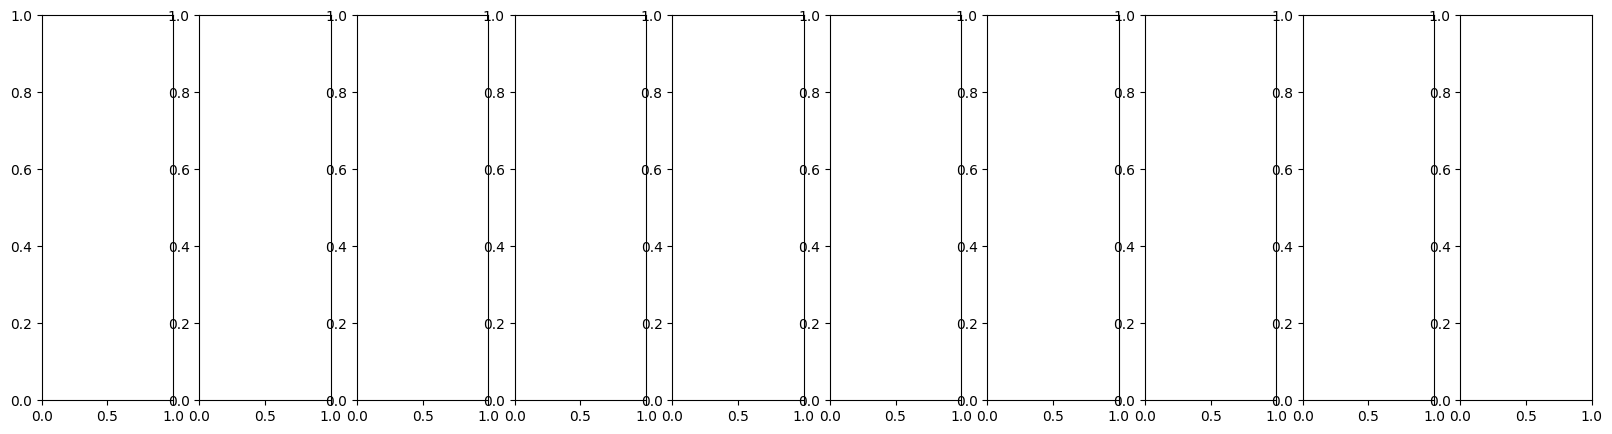

In [ ]:
def predict(image):
    # Убедитесь, что изображение имеет размерность (1, 1, 28, 28)
    #if image.dim() == 3:  # Если размерность 3, значит (1, 28, 28)
    image = image.unsqueeze(0)  # Добавляем размер батча: теперь будет (1, 1, 28, 28)

    print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем символ предсказанного класса
        print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    #image_np = image.squeeze().numpy()  # Прямое преобразование в NumPy массив и убираем размер батча

    # Предсказание для изображения
    pred = predict(image)  # Передаем изображение без изменений, оно должно быть в правильном формате

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()

Random index: 92375
image shape: torch.Size([1, 1, 28, 28])


AttributeError: 'CNNModel' object has no attribute 'pool'

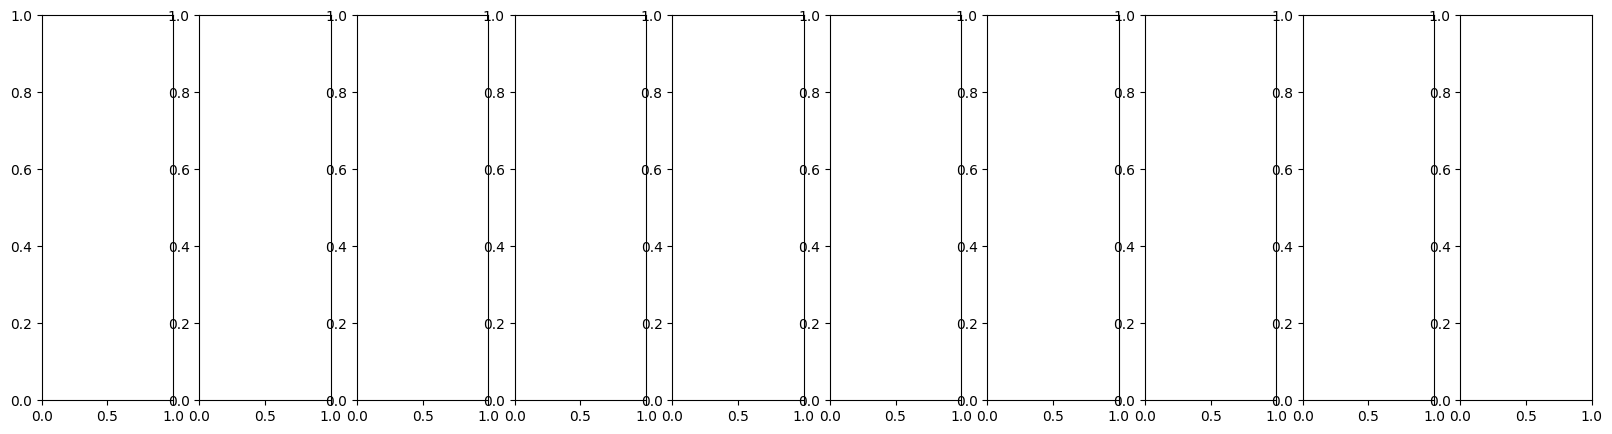

In [ ]:
def predict(image):
    # Применяем преобразования к изображению
    #image = transform(input_image)  # 
    #image = image.unsqueeze(0)  # Добавляем размер батча

    print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # 
        print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()

In [ ]:
def predict(image):
    # Добавляем размер батча
    #image = image.unsqueeze(0)  # Теперь shape будет [1, channels, height, width]

    print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число

        pred = label_dict[predicted_label]  # 

    return pred

Random index: 38950
image shape: torch.Size([1, 28, 28])


ValueError: expected 4D input (got 3D input)

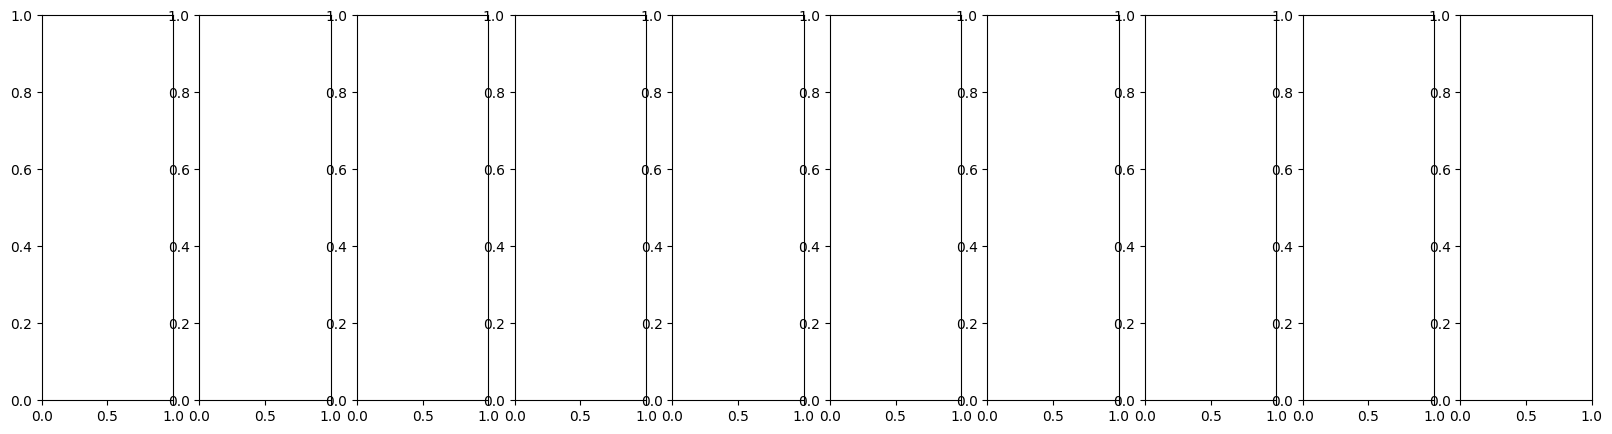

In [ ]:
# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()

ValueError: expected 4D input (got 3D input)

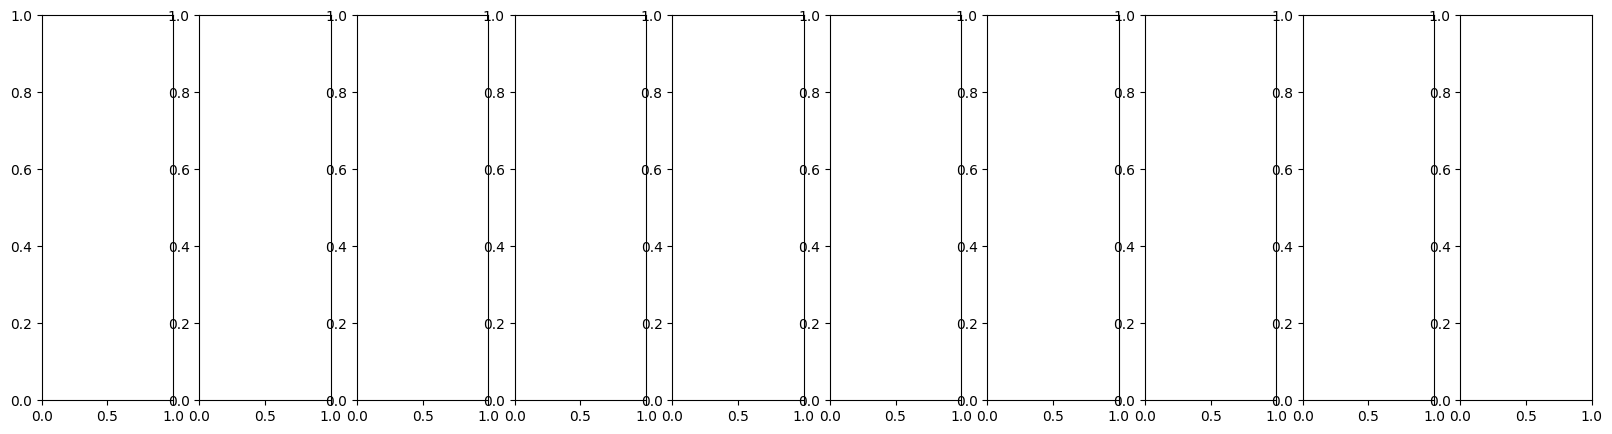

In [ ]:


# Проверяем предсказания для цветных изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  
        image_np = image_np.squeeze(0)  # Убираем размерность канала
    elif image_np.shape[0] == 3:  
        image_np = image_np.transpose(1, 2, 0)  # Меняем порядок на [height, width, channels]

    pred = predict(image)  # Предсказание для изображения
    #print('Predicted:', pred)

    # Отображаем изображение
    axs[i].imshow(image_np)
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()


In [ ]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'myapp/model.ckpt')


In [ ]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'model.ckpt')

In [ ]:
# Сохранение обученной модели
checkpoint = {
    'model_state_dict': model_cnn.state_dict(),  # Состояние модели
    'optimizer_state_dict': optimizer.state_dict(),  # Состояние оптимизатора
    #'epoch': n_epoch  # Текущий номер эпохи (если нужно возобновить обучение)
}

In [ ]:
# Сохранение контрольной точки в файл .ckpt
torch.save(checkpoint, 'data/model_mlp.ckpt')

### Загрузка модели из контрольной точки

 загрузить модель из сохраненного файла .ckpt:



In [ ]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model.ckpt')

# Восстановление состояния модели и оптимизатора
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']

/tmp/ipykernel_5591/1590141383.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model.ckpt')


In [ ]:
# Переключение модели в режим оценки
#model_mlp.eval()

## Дообучение модели

In [ ]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model.ckpt')

/tmp/ipykernel_5591/3372814224.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model.ckpt')


In [ ]:
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
n_epochs = checkpoint['epoch']

In [ ]:
# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

In [ ]:
# Параметры для продолжения обучения
n_epochs_to_continue = 5  # Количество дополнительных эпох

In [ ]:

for epoch in range(start_epoch, start_epoch + n_epochs_to_continue):
    model_cnn.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch}/{start_epoch + n_epochs_to_continue}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 11/16, Loss: 0.1662
Validation Accuracy: 0.8663
Epoch 12/16, Loss: 0.1539
Validation Accuracy: 0.8654
Epoch 13/16, Loss: 0.1447
Validation Accuracy: 0.8648
Epoch 14/16, Loss: 0.1369
Validation Accuracy: 0.8611
Epoch 15/16, Loss: 0.1261
Validation Accuracy: 0.8630


In [ ]:
# Сохранение новой контрольной точки после дообучения
new_checkpoint = {
    'model_state_dict': model_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}


In [ ]:
# Сохранение обновленной модели
torch.save(model_cnn.state_dict(), 'data/model_updated.ckpt')

# Итоговая модель

In [ ]:
class CNNModel(nn.Module):
    """Определение сверточной нейронной сети с Dropout и Batch Normalization."""
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Первый сверточный блок
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Свертка с 32 фильтрами
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization после первого свертки
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Подвыборка
        self.dropout1 = nn.Dropout(0.25)  # Dropout после первого блока

        # Второй сверточный блок
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Свертка с 64 фильтрами
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization после второго свертки
        self.dropout2 = nn.Dropout(0.25)  # Dropout после второго блока

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Полносвязный слой
        self.dropout3 = nn.Dropout(0.5)  # Dropout перед выходным слоем
        self.fc2 = nn.Linear(128, 47)  # Выходной слой для 47 классов

    def forward(self, x):
        """Определяет поток данных через слои при прямом прохождении через сеть."""
        
        # Первый сверточный блок
        x = F.relu(self.bn1(self.conv1(x)))  # Применение свертки и активации ReLU
        x = self.dropout1(x)  # Применение Dropout
        x = self.pool(x)  # Подвыборка
        
        # Второй сверточный блок
        x = F.relu(self.bn2(self.conv2(x)))  # Применение свертки и активации ReLU
        x = self.dropout2(x)  # Применение Dropout
        x = self.pool(x)  # Подвыборка
        
        x = x.view(-1, 64 * 7 * 7)  # Преобразование в вектор для полносвязного слоя
        
        x = F.relu(self.fc1(x))  # Полносвязный слой с активацией ReLU
        x = self.dropout3(x)  # Применение Dropout перед выходным слоем
        
        x = self.fc2(x)  # Выходной слой без активации (для использования с CrossEntropyLoss)
        
        return x

In [ ]:
# Инициализация модели и оптимизатора
model_final = CNNModel()
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_final.parameters(), lr=0.001)  
loss_function = nn.CrossEntropyLoss() 

In [ ]:
n_epochs = 10

for epoch in range(n_epochs):
    model_final.train()  
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  
        output = model_final(data)  
        loss = loss_function(output, target)  
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    model_final.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_final(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 1.6026
Validation Accuracy: 0.7828
Epoch 2/10, Loss: 1.1927
Validation Accuracy: 0.8073
Epoch 3/10, Loss: 1.0925
Validation Accuracy: 0.8212
Epoch 4/10, Loss: 1.0166
Validation Accuracy: 0.8366
Epoch 5/10, Loss: 0.9526
Validation Accuracy: 0.8338
Epoch 6/10, Loss: 0.9140
Validation Accuracy: 0.8474
Epoch 7/10, Loss: 0.8824
Validation Accuracy: 0.8489
Epoch 8/10, Loss: 0.8474
Validation Accuracy: 0.8532
Epoch 9/10, Loss: 0.7973
Validation Accuracy: 0.8559
Epoch 10/10, Loss: 0.7625
Validation Accuracy: 0.8551


In [ ]:
# Сохранение модели в формате .ckpt
torch.save(model_final.state_dict(), 'myapp/model.ckpt')

In [ ]:
# Сохранение новой контрольной точки после дообучения
new_checkpoint = {
    'model_state_dict': model_final.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}

In [ ]:
# Сохранение контрольной точки в файл .ckpt
torch.save(new_checkpoint, 'data/model_mlp.ckpt')